# WS2332 - Project 7 - Lecture 3
Miguel Bessa
<div>
<img src=docs/tudelft_logo.jpg width=300px></div>

**What:** Lab Session 2 of course WS2332 (Project 7): Introduction to Machine Learning

* Today's lecture **continues** the topic of **regression via supervised learning in 1D**

**How:** Jointly workout this notebook
* GitHub: https://github.com/mabessa/Intro2ML
    1. You can do this locally in your computer (but you have to have the Python packages installed):
        * clone the repository to your computer: git clone https://github.com/mabessa/Intro2ML
        * load jupyter notebook (it will open in your internet browser): jupyter notebook
        * search for this notebook in your computer and open it
    2. Or you can use Google's Colab (no installation required, but times out if idle):
        * go to https://colab.research.google.com
        * login
        * File > Open notebook
        * click on Github (no need to login or authorize anything)
        * paste the git link: https://github.com/mabessa/Intro2ML
        * click search and then click on the notebook.


This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957

It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

License: BSD 3 clause

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)
    #return np.sin(x)*np.cos(x)**2.0

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

x_train = X_train.ravel() # just for plotting later
x_test = X_test.ravel() # just for plotting later

# Outline for today

1. Introduction to Gaussian Processes
2. Using Scikit-learn for Gaussian Process Regression (noiseless and noisy datasets)
3. Introduction to Artificial Neural Networks
4. Using Keras for regression with Artificial Neural Networks (noiseless and noisy datasets)

# 1. Introduction to Gaussian Processes

### Recommended literature:

Gaussian Processes are a Bayesian machine learning method that is easy to train and performs very well for small datasets.

In this class, we will follow a beautiful introductory article written by Gortler et al.:

* Görtler, J., Kehlbeck, R., & Deussen, O. (2019). A Visual Exploration of Gaussian Processes. Distill, 4(4), e17.

If you want to know more details about the method:

* Rasmussen, C. E., & Williams, C. (2006). Gaussian processes for machine learning, ser. Adaptive computation and machine learning. Cambridge, MA, USA: MIT Press, 38, 715-719.

And if you are curious about the role of kernels and how to choose them (kernel engineering), I recommend the following PhD thesis:

* Duvenaud, D. (2014). Automatic model construction with Gaussian processes (Doctoral dissertation, University of Cambridge).

### Key concepts behind Gaussian Processes

Let's have a quick introduction to the topic by considering the problem of regression of one-dimensional functions (input $X$ and output $Y$). We will follow Görtler et al. (2019) but with a different notation: https://distill.pub/2019/visual-exploration-gaussian-processes

* In Gaussian Processes **each** OUTPUT value $Y_i$ in the training data is treated as a random variable that follows a Gaussian distribution:

    $\mathbf{Y} = \begin{bmatrix}Y_1\\ Y_2 \\ \vdots\\ Y_n \end{bmatrix} \sim \mathcal{N}(\boldsymbol{\mu} , \boldsymbol{\Sigma})$

    and where the joint distribution of all the output values $\mathbf{Y}$ is also Gaussian (a multivariate Gaussian) defined by a mean vector $\boldsymbol{\mu}$ and a covariance matrix $\boldsymbol{\Sigma}$. The mean is usually assumed to be zero.


* Before considering how to calculate $\boldsymbol{\Sigma}$, just look at **Figure 1** of the article that is showing a two-dimensional Gaussian centered around the means $(\mu_1,\,\mu_2)$ and whose shape is controlled by the covariance matrix $\boldsymbol{\Sigma}$. Note that if we change the covariance matrix $\boldsymbol{\Sigma}$, the multivariate Gaussian distribution also changes... Let's play with it a bit: https://distill.pub/2019/visual-exploration-gaussian-processes/#Multivariate


* Formally, the expression for the covariance matrix depends on the "covariance function" or "kernel" $k$ that is calculated for **each** pair of INPUT points $X_i$ and $X_j$:

    $\Sigma_{ij} = \text{Cov}(Y_i,Y_j) = k(X_i,X_j)+\alpha_i^2 \delta_{ij}  \quad \Rightarrow \quad \boldsymbol{\Sigma} = \mathbf{K} + \mathbf{R} $

    where the kernel $k(X_i,X_j)$ can be many different kinds of functions (with some special properties) and $\alpha_i^2$ is the noise level of $Y_i$.


* An example of a kernel function is the RBF: $k(X_i,X_j) = {\color{red}\eta}^2\exp{\left(-\frac{||X_i-X_j||^2}{2{\color{red}\lambda}^2}\right)}$


* Every kernel function has a set of unknown parameters (in red) that are called **hyperparameters**. The RBF has 2 hyperparameters. You can visualize different kernel functions in this figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#MultipleKernels


* In the Gaussian Process method, we start by **assuming** a kernel function with an **initial guess** for the values of the hyperparameters. This defines our **prior** information in conjunction with the assumption that the variables follow a multivariate Gaussian distribution:

    $\begin{bmatrix}\mathbf{Y}\\ Y^* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0} , \, \begin{bmatrix}\mathbf{K}+\mathbf{R} & \mathbf{k}_*\\ \mathbf{k}_*^T & k(X^*,X^* \end{bmatrix}\right)$


* Multivariate Gaussian distributions have very interesting properties and it turns out that based on the above assumptions a Gaussian Process predicts both the **mean** and the **variance** of the output point $Y^*$ by the following matrix operations:

    $\text{mean}[Y^*]=\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{Y}$

    $\text{Cov}[Y^*]=k(X^*,X^*)-\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{k}_*$


* The <span style="color:red">**key concept**</span> is that the prediction of the mean and variance of the new point $Y^*$ depends on the values of the hyperparameters of the kernel function (which are **UNKNOWN**).


* However, despite the fact that we don't know the hyperparameters of the kernel function, they can be obtained by **Bayesian inference**, i.e. using Bayes rule to find the **posterior** information. This involves doing Marginalization and Conditioning. We will not cover how to do this here. However, we can at least visualize what it means to Marginalize $Y^*$ and to condition $Y$ in this figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#MarginalizationConditioning

   * Marginalizing for $Y^*$ means to integrate along the $Y$ axis
    
   * Conditioning $Y$ means to cut trough the original distribution for a particular value of $Y$

### Prior Distribution

The first contact with the concept of prior distribution is a bit strange.

* Prior distribution is just the multivariate Gaussian distribution obtained for a particular choice of kernel function **before** even considering ANY training data.

* Conceptually, it represents the distribution of functions that will be used in the regression process to obtain the **posterior** distribution

* There is a beautiful interactive figure about this here: https://distill.pub/2019/visual-exploration-gaussian-processes/#Prior


### Posterior distribution

* This is the distribution of functions that we obtain by using the training data to **constrain** the set of functions that pass through the training points

* Here's another interactive figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#Posterior


### A short word about kernel "engineering"

As we can see, the choice of kernel affects the type of functions used in the fitting process. For example, the RBF kernel is infinitely smooth, so the approximation obtained from a Gaussian Process using RBF will be infinitely differentiable. This may not be adequate for specific applications...

In addition, we can also combine different kernels by multiplying or adding different basic kernels (RBF with Linear kernel, for example).

* As mentioned in the beginning of this notebook, Duvenaud (2014) has elaborated on this topic significantly in his PhD thesis. He also has a website with a short "cookbook" for kernel engineering: https://www.cs.toronto.edu/~duvenaud/cookbook/

In your assignment, you will explore the influence that the choice of kernel has in the quality of the approximations.

# Using Scikit-learn for Gaussian Process Regression (noiseless and noisy datasets)

### GPs with noiseless dataset

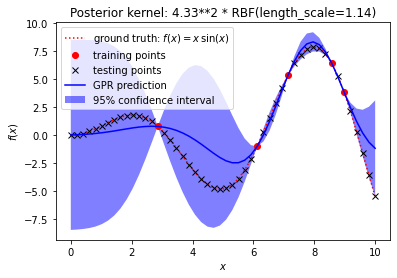

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_train)

# Make the prediction on the entire dataset (for plotting)
y_data_pred, sigma_data = gp_model.predict(X_data, return_std=True) # also output the uncertainty (standard deviation)

# Predict for test set (for error metric)
y_pred, sigma = gp_model.predict(X_test, return_std=True) # also output the uncertainty (standard deviation)


# Plot the function, the prediction and the 95% confidence interval based on the MSE
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

ax1.plot(x_train, y_train, 'ro', markersize=6, label="training points") # noiseless data

ax1.plot(x_test, y_test, 'kx', markersize=6, label="testing points") # Plot test points

ax1.plot(x_data, y_data_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_data_pred - 1.9600 * sigma_data,
                        (y_data_pred + 1.9600 * sigma_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$f(x)$')
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=12) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left')

### Exercise 1

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [3]:
# Exercise 1.

# Write here.

# until here.

Gaussian Process Regression approximates the function much better...

* However, the **choice of kernel** used in GPR affects the quality of the prediction.

### GPs with noisy dataset

Let's create the noisy dataset again that we created in Lab Session 1:

In [4]:
# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape)
noise = np.random.normal(0, random_std) 
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
x_train = X_train[:]
x_test = X_test[:]


y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

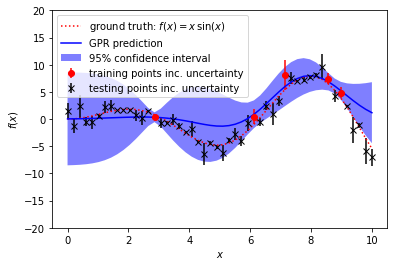

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Instanciate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Fitting for noisy data, if we have access to the uncertainty
# at the training points is equivalent to include the noise level
# at the alpha parameter (as we saw above)
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_train**2, n_restarts_optimizer=5) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_noisy_train)

# Make the predictions
y_noisy_pred, sigma_noisy = gp_model.predict(X_test, return_std=True) # also output the uncertainty (standard deviation)
y_noisy_data_pred, sigma_noisy_data = gp_model.predict(X_data, return_std=True) # also output the uncertainty (standard deviation)

# Plot the function, the prediction and the 95% confidence interval based on the MSE
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

plt.errorbar(x_train, y_noisy_train, noise_train, fmt='ro', markersize=6, label=u'training points inc. uncertainty')


plt.errorbar(x_test, y_noisy_test, noise_test, fmt='kx', markersize=6, label=u'testing points inc. uncertainty')

plt.plot(x_data, y_noisy_data_pred, 'b-', label="GPR prediction")
plt.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_noisy_data_pred - 1.9600 * sigma_noisy_data,
                        (y_noisy_data_pred + 1.9600 * sigma_noisy_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-20, 20)
plt.legend(loc='upper left')

### Exercise 2

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [6]:
# Exercise 2.

# Write here.

# until here.

Well done...

In the Lab Assignment you will be further exploring Gaussian Processes.

# 3. Introduction to Artificial Neural Networks

This introduction is a selection of materials from the course of Andreas Mueller (Lecture 22): https://github.com/amueller/COMS4995-s19

## Neural network with one hidden layer

<div>
<img style="float: left"; src=docs/nn_basic_arch.png width=500px></div>

Each circle represents a node (called neurons).

Input layer: number of neurons equals number of features of our data

Each connection of a hidden layer: $ h(x) = f(W_1x+b_1) $

Output layer: $ o(x) = g(W_2h(x) + b_2) $

## Neural network with two hidden layers

<div>
<img style="float: left"; src=docs/nn_manylayers.png width=500px></div>

This is called a multilayer perceptron or fully-connected feed-forward neural network.

* Neurons in hidden layers usually have the same non-linear function (ReLu is popular), weights are different for every neuron.

* Many layers $\rightarrow$ “deep learning”.

* In theory: more hidden layers $\rightarrow$ more complex functions and feature representation. But there's more to this story...

* For regression each output neuron corresponds to a single output variable and the last layer uses a linear activation function.

## Examples of nonlinear activation functions

<div>
<img style="float: left"; src=docs/nonlin_fn.png width=500px></div>

* ReLu is the most common choice nowadays (easier optimization)

* tanh has small gradients in most places (harder to optimize)

## Quick overview about neural networks

* Non-linear regression models

* Powerful for very large datasets

* Non-convex optimization

* Notoriously slow to train (state of the art models take days or even weeks to train, often on multiple GPUs)

* Important to scale and transform the data properly (preprocessing)

* MANY variants (Convolutional nets, Recurrent neural networks, variational autoencoders, generative adversarial networks, deep reinforcement learning, ...)

## Training Objective

$ h(x) = f(W_1x+b_1) $
$ o(x) = g(W_2h(x)+b_2) = g(W_2f(W_1x + b_1) + b_2)$

$ \min_{W_1,W_2,b_1,b_2} \sum\limits_{i=1}^N l(y_i,o(x_i)) $

$ =\min_{W_1,W_2,b_1,b_2} \sum\limits_{i=1}^N l(y_i,g(W_2f(W_1x+b_1)+b_2)$

- $l$ is the MSE (or squared loss function) for regression.

## Backpropagation

* Need $ \frac{\partial l(y, o)}{\partial W_i} $ and $\frac{\partial l(y, o)}{\partial b_i}$


* Example for network with one hidden layer where $ \text{net}(x) := W_1x + b_1 $

<div>
<img style="float: left"; src=docs/backprop_eqn.png width=400px></div>

## Optimizing W, b

* Batch

    $ W_i \leftarrow W_i - \eta\sum\limits_{j=1}^N \frac{\partial l(x_j,y_j)}{\partial W_i} $


* Online/Stochastic

    $ W_i \leftarrow W_i - \eta\frac{\partial l(x_j,y_j)}{\partial W_i}$


* Minibatch

    $ W_i \leftarrow W_i - \eta\sum\limits_{j=k}^{k+m} \frac{\partial l(x_j,y_j)}{\partial W_i}$
    

**A nice resource about optimizers** to understand what is learning rate (step size) and momentum: https://distill.pub/2017/momentum/


To note:

1. Standard gradient descent with constant learning rate (or step size) $\eta$ is slow because we update a weight matrix $W_i$ using the old $W_i$ and taking a gradient step after summing over the whole training set.

    * Using the entire training set for each forward pass through the network means that we need to make predictions for every point (without updating the weights) and then do a backward pass with backpropagation... One forward pass and one backward pass is what we call an epoch. So, if we do this, a single epoch has a lot of matrix multiplications to do a single gradient step.
    
    
2. To speed this up we can do a stochastic approximation, i.e. stochastic gradient descent (or online gradient descent). Here, you pick a sample at random, compute the gradient just considering that sample, and then update the parameter. So you update the weights much more often, but you have a much less stable estimate of the gradient. In practice, we often just iterate through the data instead of picking a sample at random. And as with linear models, this is much faster than doing full batches for large datasets.

    * Stochastic grandient descent is less stable (of course!).
    
    
3. A compromise is to consider batch sizes of $k$ samples of the training set (also called mini-batches). For example, we could use 64 points per epoch (one forward and backward pass). In other words: we look at $k=64$ samples, compute the gradients, average them, and update the weights. That allows us to update much more often than looking at the whole dataset, while still having a more stable gradient. This strategy is easy to parallelize in modern CPUs and GPUs and it is very commonly used in practice. The reason why this is faster is basically that doing a matrix-matrix multiplication is faster than doing a bunch of matrix-vector operations.


Finally, a short note: we could also be using smarter optimization methods, like second order methods or LBFGS, but these are often not very effective on these large non-convex problems. One, called levenberg-marquardt is actually a possibility, but it's not really used these days.

# Learning Heuristics

* Constant learning rate $\eta$ not good


* Better: adaptive $\eta$ for each entry of $W_i$ (large $\eta$ in the beginning and small at the end)


* Common approach: adam optimizer


* There are many variants of optimizers... Remember: you will often get different solutions depending on how you pick the learning rate because you are solving a (very) non-convex problem. It's nearly impossible to actually find a global optimum. So nearly all of these strategies are heuristics, that have just proven well to work in practice.

# Complexity Control

These are the main ways to control complexity.

* Decrease number of parameters


* Regularization:

    * L2 & L1 regularization (just like what you did [will do] in the Lab Assignment for Regularized Least Squares)
    * Dropout: randomly prune neurons from the network


* Early Stopping:

    * Early stopping means that you compute the loss from a validation set and then you stop when you start to overfit.

In [7]:
# -----------------------------------------------------------
# Neural Networks example
# KERAS:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
#
# Function to create model, required for KerasClassifier when SPECIFYING INPUTS
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # thrid hidden layer
    #model.add(Dense(neurons4, activation=activation)) # fourth hidden layer, etc.
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=optimizer)
    return model
# -----------------------------------------------------------------------------
#

scaler = StandardScaler().fit(X_train)
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_data_scaled=scaler.transform(X_data)
#

# Do you want to look for the best parameters for the Neural Network?
# (slower)
gridsearch = 0

if gridsearch==1:
    # create model
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
#    NN_model = KerasRegressor(build_fn=create_model(input_dimensions=1,neurons=20),
#                              callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    # define the grid search parameters
    neurons1 = [5,20,200] # number of neurons in hidden layer 1
    neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
    neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_model function)
    neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_model function)
    #
    batch_size = [len(X_train)]
    #
    epochs = [1000]
    #
    optimizer = ['adam']
#    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#    init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
    #
    param_grid = dict(batch_size=batch_size, epochs=epochs,neurons1=neurons1,
                      neurons2=neurons2,
                      #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                      optimizer=optimizer)
    NN_model = KerasRegressor(build_fn=create_model)
    grid = GridSearchCV(estimator=NN_model, param_grid=param_grid, n_jobs=1, cv=3, iid=False)
    grid_result = grid.fit(X_train_scaled, y_train, callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    history = grid_result.best_estimator_.fit(X_train_scaled, y_train,callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
else: # just use a particular Neural Network of choice
    # Define early stopping:
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')
    neurons1=200
    neurons2=10
    NN_model = KerasRegressor(build_fn=create_model, neurons1=neurons1, neurons2=neurons2,
                              batch_size=len(X_train), epochs=1000, optimizer='adam',
                              callbacks=[early_stopping],
                              validation_data=(scaler.transform(X_test), y_test))
    #
    history = NN_model.fit(X_train_scaled, y_train)

Using TensorFlow backend.


Train on 5 samples, validate on 45 samples
Epoch 1/1000
5/5 [==============================] - 1s 123ms/step - loss: 17.0947 - val_loss: 14.0492
Epoch 2/1000
5/5 [==============================] - 0s 2ms/step - loss: 16.9317 - val_loss: 14.0487
Epoch 3/1000
5/5 [==============================] - 0s 2ms/step - loss: 16.7715 - val_loss: 14.0531
Epoch 4/1000
5/5 [==============================] - 0s 3ms/step - loss: 16.6135 - val_loss: 14.0612
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 16.4574 - val_loss: 14.0706
Epoch 6/1000
5/5 [==============================] - 0s 4ms/step - loss: 16.3039 - val_loss: 14.0794
Epoch 7/1000
5/5 [==============================] - 0s 4ms/step - loss: 16.1529 - val_loss: 14.0818
Epoch 8/1000
5/5 [==============================] - 0s 3ms/step - loss: 16.0021 - val_loss: 14.0780
Epoch 9/1000
5/5 [==============================] - 0s 4ms/step - loss: 15.8485 - val_loss: 14.0665
Epoch 10/1000
5/5 [==============================] - 0s

Epoch 83/1000
5/5 [==============================] - 0s 4ms/step - loss: 2.8940 - val_loss: 14.0407


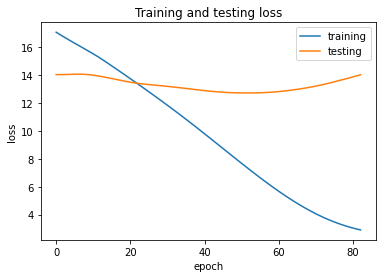

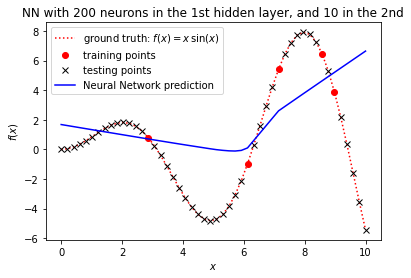

In [8]:
#
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and testing loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'testing'], loc='upper right')
plt.show()

# Plot the function
fig = plt.figure()
plt.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$')

plt.plot(x_train, y_train, 'ro', markersize=6, label="training points")

# Plot test points
plt.plot(x_test, y_test, 'kx', markersize=6, label="testing points")

y_pred = history.model.predict(X_data_scaled)
plt.plot(x_data, y_pred, 'b-', label="Neural Network prediction")
plt.title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd')

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')

Note that this neural network approximation is not brilliant...

## Exercise 3

Redo the neural network regression but now for the noisy dataset.

In [9]:
# Exercise 3.

# Write here.

#until here.

Have fun with the Lab Assignment...